In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)

/kaggle/input
/kaggle/input/kitte-dataset
/kaggle/input/kitte-dataset/training
/kaggle/input/kitte-dataset/training/label_2
/kaggle/input/kitte-dataset/training/image_2


In [2]:
import os
import shutil
import cv2
import yaml
from sklearn.model_selection import train_test_split

# This script does the following:

* Converts the KITTI annotations to YOLO format.
* Splits the dataset into training, validation, and test sets.
* Moves the files to the appropriate directories.
* Creates a data.yaml file required for training YOLO models.

In [3]:

# Define paths
kitti_base_path = '/kaggle/input/kitte-dataset/training'
yolo_base_path = '/kaggle/working/yolo'  # Use a writable directory
images_path = os.path.join(kitti_base_path, 'image_2')
labels_path = os.path.join(kitti_base_path, 'label_2')
yolo_images_path = os.path.join(yolo_base_path, 'images')
yolo_labels_path = os.path.join(yolo_base_path, 'labels')

# Create YOLO directories
os.makedirs(yolo_images_path, exist_ok=True)
os.makedirs(yolo_labels_path, exist_ok=True)

kitti_classes = ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc']

# Define function to convert KITTI bbox to YOLO bbox
def convert_bbox(size, box):
    dw = 1. / size[0]
    dh = 1. / size[1]
    x = (box[0] + box[1]) / 2.0
    y = (box[2] + box[3]) / 2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return (x, y, w, h)

# Process each label file
for label_file in os.listdir(labels_path):
    if not label_file.endswith('.txt'):
        continue
    image_file = label_file.replace('.txt', '.png')

    image = cv2.imread(os.path.join(images_path, image_file))
    h, w, _ = image.shape

    with open(os.path.join(labels_path, label_file), 'r') as lf:
        lines = lf.readlines()
    yolo_labels = []
    for line in lines:
        elements = line.strip().split(' ')
        class_id = elements[0]
        if class_id in kitti_classes:
            class_id = kitti_classes.index(class_id)  # In KITTI, the first element is the class
            xmin, ymin, xmax, ymax = map(float, elements[4:8])
            bbox = convert_bbox((w, h), (xmin, xmax, ymin, ymax))
            yolo_labels.append(f"{class_id} {' '.join(map(str, bbox))}\n")

    with open(os.path.join(yolo_labels_path, label_file), 'w') as yf:
        yf.writelines(yolo_labels)
    # Copy image to YOLO directory
    shutil.copy(os.path.join(images_path, image_file), yolo_images_path)

# Split dataset into train, val, test sets
all_images = [f for f in os.listdir(yolo_images_path) if f.endswith('.png')]
train_images, test_images = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

# Function to move files to appropriate directories
def move_files(file_list, dest_dir):
    os.makedirs(os.path.join(dest_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(dest_dir, 'labels'), exist_ok=True)
    for file_name in file_list:
        shutil.move(os.path.join(yolo_images_path, file_name), os.path.join(dest_dir, 'images', file_name))
        label_file = file_name.replace('.png', '.txt')
        shutil.move(os.path.join(yolo_labels_path, label_file), os.path.join(dest_dir, 'labels', label_file))

# Move files to train, val, test directories
move_files(train_images, os.path.join(yolo_base_path, 'train'))
move_files(val_images, os.path.join(yolo_base_path, 'val'))
move_files(test_images, os.path.join(yolo_base_path, 'test'))

print("Conversion and splitting complete.")



# Define the data dictionary
data = {
    'train': '/kaggle/working/yolo/train/images',
    'val': '/kaggle/working/yolo/val/images',
    'test': '/kaggle/working/yolo/test/images',
    'nc': 8,  # number of classes
    'names': ['Car', 'Van', 'Truck', 'Pedestrian', 'Person_sitting', 'Cyclist', 'Tram', 'Misc']
}

# Save to data.yaml
with open('/kaggle/working/yolo/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

print("data.yaml file created successfully.")


Conversion and splitting complete.
data.yaml file created successfully.


In [4]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt


Cloning into 'yolov5'...
remote: Enumerating objects: 17093, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 17093 (delta 23), reused 8 (delta 7), pack-reused 17057 (from 5)
Receiving objects: 100% (17093/17093), 15.70 MiB | 30.69 MiB/s, done.
Resolving deltas: 100% (11728/11728), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 58.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 905.3/905.3 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 69.0.3
    Uninstalling setuptools-69.0.3:
      Successfully uninstalled setuptools-69.0.3
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Succes

In [9]:
!python train.py --img 640 --batch 16 --epochs 5 --data /kaggle/working/yolo/data.yaml --weights yolov5s.pt --cache


wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-07 23:03:06.191847: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 23:03:06.191914: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 23:03:06.193574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train:

In [15]:
!python val.py --weights /kaggle/working/yolov5/runs/train/exp2/weights/best.pt --data /kaggle/working/yolo/data.yaml --img 640 --conf-thres 0.25


val: data=/kaggle/working/yolo/data.yaml, weights=['/kaggle/working/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.25, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
WARNING ⚠️ confidence threshold 0.25 > 0.001 produces invalid results
YOLOv5 🚀 v7.0-393-g6981c274 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /kaggle/working/yolo/val/labels.cache... 748 images, 0 backgrounds
                 Class     Images  Instances          P          R      mAP50   
                   all        748       4083      0.518      0.536      0.562      0.348
                   Car        748       2905      0.752      0.865       0.89      0.618
          

In [ ]:
# Path to test images
test_images_path = '/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2'

# Run inference on test images
!python detect.py --weights /kaggle/working/yolov5/runs/train/exp2/weights/best.pt --img 640 --conf 0.25 --source {test_images_path}

# Output directory: /kaggle/working/yolo/runs/detect/exp


detect: weights=['/kaggle/working/yolov5/runs/train/exp2/weights/best.pt'], source=/kaggle/input/kitti-dataset/data_object_image_2/testing/image_2, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-393-g6981c274 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7031701 parameters, 0 gradients, 15.8 GFLOPs
image 1/7518 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000000.png: 224x640 2 Cars, 41.9ms
image 2/7518 /kaggle/input/kitti-dataset/data_object_image_2/testing/image_2/000001.png: 224x640 3 Cars, 5.6ms
image 3/7518 /kag

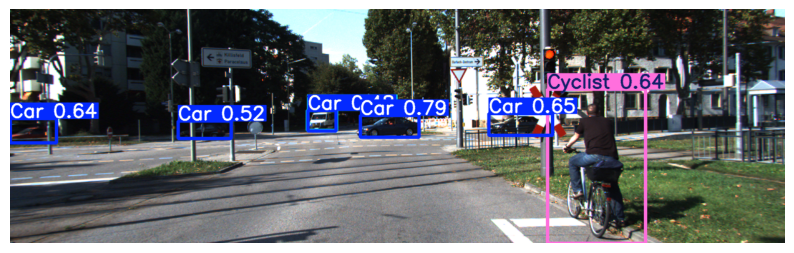

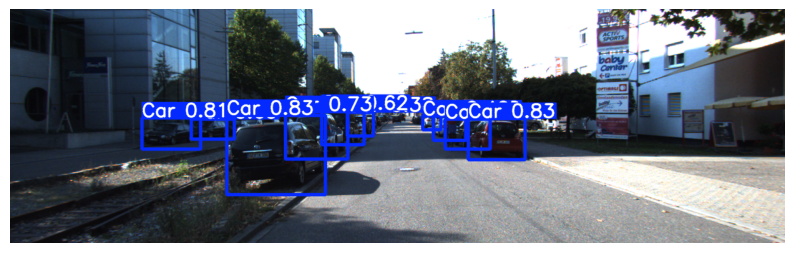

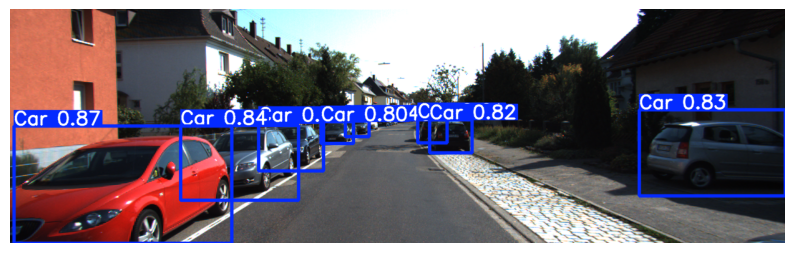

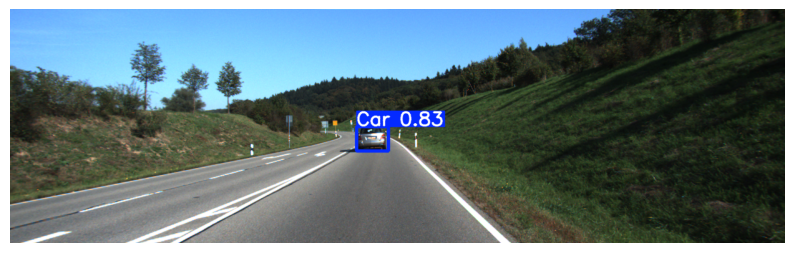

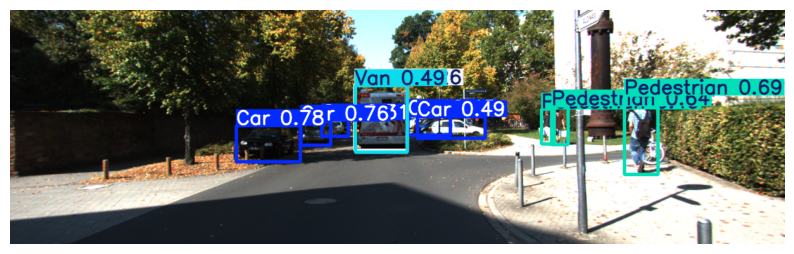

In [18]:
import cv2
import matplotlib.pyplot as plt
import os

# Path to inference results
results_path = '/kaggle/working/yolov5/runs/detect/exp3'

# Display a few images with results
result_images = [os.path.join(results_path, img) for img in os.listdir(results_path) if img.endswith('.jpg') or img.endswith('.png')]

for img_path in result_images[:5]:  # Display first 5 results
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for displaying
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
